In [118]:
# import packages
import pandas as pd
import numpy as np
import math
import random
import itertools
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib.pyplot as plt
import matplotlib as mpl
import holidays
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
import geopandas as gpd
plt.style.use('ggplot')
%matplotlib inline

In [178]:
# Path to the shapefile
shapefile_path = 'Chigaco_data\Chicago_Public_Transport\L_Shapes\CTA_RailStations.shp'

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# read climate data
climate_data = pd.read_csv("Chigaco_data/chicago_weather.csv")

# read turnstile data
daily_totals = pd.read_csv("Chigaco_data/Chicago_Public_Transport/Train_Turnstiles_2001-2023.csv")
# daily_totals = pd.read_csv("Chigaco_Data/Chicago_Public_Transport/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv")
gdf["STATION_ID"] = gdf["STATION_ID"] + 40000
### merge on station_id and STATION_ID

CHI_trains = pd.merge(gdf, daily_totals, left_on="STATION_ID", right_on="station_id")
community_zones = gpd.read_file("Chigaco_data/boundaries_community_areas_chicago.geojson")


gdf1 = gpd.GeoDataFrame(CHI_trains, geometry='geometry')
gdf2 = gpd.GeoDataFrame(community_zones, geometry='geometry')

if gdf1.crs != gdf2.crs:
    gdf1 = gdf1.to_crs(gdf2.crs)

merged_gdf = gpd.sjoin(gdf1, gdf2, how='left', op='within')




merged_data = pd.DataFrame(merged_gdf)
merged_data["date"] = pd.to_datetime(merged_data["date"])
climate_data["DATE"] = pd.to_datetime(climate_data["DATE"])
public_trans_shapes_climate = pd.merge(merged_data, climate_data, left_on="date", right_on="DATE")


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


## employ binned model

In [180]:
public_trans_shapes_climate.to_csv("Chigaco_data/Chicago_Public_Transport/merged_withclimate_2015-2019.csv")

In [183]:
import holidays

def fahrenheit_to_celsius(f):
        return (f - 32) * 5/9


def process_trains():
    """
    Adds timetrends and time factors to public transport data
    
    """

    

    trips = pd.read_csv("Chigaco_data/Chicago_Public_Transport/merged_withclimate_2015-2019.csv")

    # merge climate and tips on date_pickup and DATE , drop DATE column after 


    # sort by date
    trips = trips.sort_values(by=['date']).reset_index(drop=True)
    

    us_holidays = holidays.US()

    # Create a new column indicating whether each date is a holiday or not
    trips['holiday'] = trips['date'].apply(lambda x: 1 if x in us_holidays else 0)


    # Apply the conversion function to the Fahrenheit column
    trips['TMAX'] = trips['TMAX'].apply(fahrenheit_to_celsius)

    # add a weekday index to the dataframe starting with Mondays = 0 tuesdays = 1 etc.
    trips['Weekday_index'] = pd.to_datetime(trips['date']).dt.dayofweek

    taxi_data = trips

    taxi_data.rename(columns={ 'TMAX' : 'tmax_obs'}, inplace=True)


    # add month and year factors
    taxi_data['Year_fact'] = pd.factorize(pd.to_datetime(taxi_data['date']).dt.year)[0] + 1
    taxi_data['Month_fact'] = pd.factorize(pd.to_datetime(taxi_data['date']).dt.month)[0] + 1
    
    # remove NAs
    taxi_data = taxi_data.dropna(subset=['tmax_obs'])

    num_days = len(taxi_data["date"].unique())
    
    taxi_data['cheby_0'] = 1
    taxi_data['cheby_1'] = taxi_data['date'].rank(method='dense').astype(int)/num_days
   
    
    # recursively defining other chebyshev polynomials for each day until 5th order
    for i in range(2, 6):
        taxi_data[f"cheby_{i}"] = (2  * taxi_data["cheby_1"] * taxi_data[f"cheby_{i-1}"]) - taxi_data[f"cheby_{i-2}"]



    taxi_data.to_csv("Chigaco_data/trains_full_2015-2019.csv", index=False)

In [187]:
process_trains()

## Binned Reg

In [196]:
def binned_regression_plots(temp_bin_size):
        
        ## 1. DATA PREPARATION
        
        taxi_data_cut = pd.read_csv("Chigaco_data/trains_full_2015-2019.csv") 


        sequence_bins = np.arange(-10, 41, temp_bin_size)
        temp_bins = pd.cut(taxi_data_cut['tmax_obs'], bins=sequence_bins, include_lowest=True, ordered = True)
        taxi_data_cut['temp_bins'] = temp_bins

        # rename bins so linearmodels can handle them

        taxi_data_cut['temp_bins'] = pd.Categorical(taxi_data_cut['temp_bins'], ordered=False).astype(str)
        # rename bins so linearmodels can handle them
        taxi_data_cut['temp_bins'] = taxi_data_cut['temp_bins'].str.replace('\(', '[', regex=True)
        # Create a panel data structure
        taxi_data_cut["date_pickup"] = pd.to_datetime(taxi_data_cut["date"])

        # remove stations which are outside of the community zones
        taxi_data_cut = taxi_data_cut[taxi_data_cut["area_num_1"].notna()]


        taxi_data_cut["PULocationID"] = taxi_data_cut["area_num_1"].astype(int)
        panel_data = taxi_data_cut.set_index(['PULocationID', 'Year_fact'])
        panel_data = panel_data[panel_data['temp_bins'] != 'nan']

        panel_data["log_total"] = np.log(panel_data["rides"] + 1)


        # Create a new DataFrame with unique days
        unique_days = taxi_data_cut[['date_pickup', 'temp_bins']].drop_duplicates()

        # Count the occurrences of each bin, respecting the categorical order
        temp_bin_counts = unique_days['temp_bins'].value_counts().sort_index()

        # Only plot bins with more than one day
        temp_bin_counts = temp_bin_counts[temp_bin_counts > 1]
        # Find the index of the maximum count
        max_days_bin = temp_bin_counts.idxmax()


        panel_data.to_csv("Chigaco_data/train_prezone_2015-2019.csv")

        ##  2. REGRESSIONS


        
        model_formula = f'log_total ~ 1+  C(temp_bins, Treatment(reference = "{max_days_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
        model = PanelOLS.from_formula(model_formula, data=panel_data)
        results1 = model.fit(cov_type='clustered', cluster_entity=True)

        co = pd.DataFrame(results1.params)
        coefficients_temp_bins = co[co.index.str.startswith('C(temp_bins')]

        if all(coefficients_temp_bins.parameter < 0):
                max_bin = max_days_bin
        
        else:
                max_id = coefficients_temp_bins.parameter.idxmax()
                parts = max_id.split('[T.')
                max_bin = parts[1].split(']')[0] + ']'
        
        model_formula = f'log_total ~ 1+  C(temp_bins, Treatment(reference = "{max_bin}")) + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5+ EntityEffects + TimeEffects'
        model = PanelOLS.from_formula(model_formula, data=panel_data)
        results = model.fit(cov_type='clustered', cluster_entity=True)

  



        ## 3. PLOTS

        coefficients = results.params
        conf_int = results.conf_int()

        # Combine coefficients and confidence intervals into a single DataFrame
        df = pd.DataFrame(pd.concat([coefficients, conf_int], axis=1))
        df.columns = ['Coefficient', 'Lower CI', 'Upper CI']
        df.reset_index(inplace=True)

        # only keep rows where index starts with C(temp_bins)
        df = df[df['index'].str.startswith('C(temp_bins')]

        # extract temperature bin string

        df['Temperature'] = df['index'].str.split(r'\[T\.').str[1].str[:-1]

        df.drop(columns=['index'], inplace=True)

        # Convert Temperature intervals into numerical values
        df['Temperature'] = df['Temperature'].str.strip('[]').str.split(',').apply(lambda x: (float(x[0]) + float(x[1])) / 2)
        # order the dataframe by temperature
        df = df.sort_values(by=['Temperature'])

        # convert the coeffients into percentages and adapt CI accordingly - only with log outcome
        
        df['Coefficient'] = df['Coefficient'] * 100
        df['Lower CI'] = df['Lower CI'] * 100
        df['Upper CI'] = df['Upper CI'] * 100

        # Extract Temperature and Coefficient values
        temperature = df['Temperature']
        coefficient = df['Coefficient']

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

        # Create the plot

        ax1.scatter(temperature, coefficient, color='blue', label='Data')
        ax1.set_ylabel(f'L-train rides response in %')
        
        
        ax1.set_title(f'L-Train (CHI) response by {temp_bin_size}°C bin- 2019-2023 - Community Zone and Year fixed effects')

        # Add confidence intervals if needed
        lower_ci = df['Lower CI']
        upper_ci = df['Upper CI']
        ax1.errorbar(temperature, coefficient, yerr=[coefficient - lower_ci, upper_ci - coefficient], fmt='o', color='red' , capsize= 3,  barsabove = True , label='Confidence Interval')

        # Fit a polynomial
        degree = 25
        coefficients_poly = np.polyfit(temperature, coefficient, degree)
        y_poly = np.polyval(coefficients_poly, temperature)

        # Plot the polynomial curve
        ax1.plot(temperature, y_poly, label=f'Polynomial Fit (Degree {degree})', color='green')

        # add a dotted line at 0 percent
        ax1.axhline(y=0, color='blue', linestyle='--')

        # Add a legend
        ax1.legend()


        sequence_bins = np.arange(-10, 41, temp_bin_size)
        temp_bins = pd.cut(taxi_data_cut['tmax_obs'], bins=sequence_bins, include_lowest=True, ordered = True)
        taxi_data_cut['temp_bins'] = temp_bins
        # Create a new DataFrame with unique days
        unique_days = taxi_data_cut[['date_pickup', 'temp_bins']].drop_duplicates()

        # Count the occurrences of each bin, respecting the categorical order
        temp_bin_counts = unique_days['temp_bins'].value_counts().sort_index()
        temp_bin_counts = temp_bin_counts[temp_bin_counts > 1]
        # Find the index of the maximum count
        max_days_bin = temp_bin_counts.idxmax()

        # Create a color array with 'grey' for all bars and 'red' for the bar with the maximum count
        color_bin= '(' + max_bin[1:]
        colors = ['grey' if str(bin) != color_bin else 'red' for bin in temp_bin_counts.index]

        # Ensure the plot respects the categorical order
        temp_bin_counts.plot(kind='bar', color=colors)
        ax2.set_title(f' Days in each {temp_bin_size}°C bin- 2014-2019')
        ax2.set_xlabel('Temperature Bins')
        ax2.set_ylabel('Number of Days')
        ax2.tick_params(axis='x', rotation=45)
        print(f"Done: Rides {temp_bin_size}")
        print(results)

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\max-admin\AppData\Local\Temp\ipykernel_4836\3551337308.py:123: RankWarning: Polyfit may be poorly conditioned
  coefficients_poly = np.polyfit(temperature, coefficient, degree)


Done: Rides 3
                          PanelOLS Estimation Summary                           
Dep. Variable:              log_total   R-squared:                        0.2157
Estimator:                   PanelOLS   R-squared (Between):             -0.0098
No. Observations:              220100   R-squared (Within):               0.2191
Date:                Thu, Dec 21 2023   R-squared (Overall):              0.1047
Time:                        15:06:18   Log-likelihood                -1.852e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2520.8
Entities:                          42   P-value                           0.0000
Avg Obs:                       5240.5   Distribution:               F(24,220030)
Min Obs:                       1797.0                                           
Max Obs:                    2.782e+04   F-statistic (robust):             863.50
              

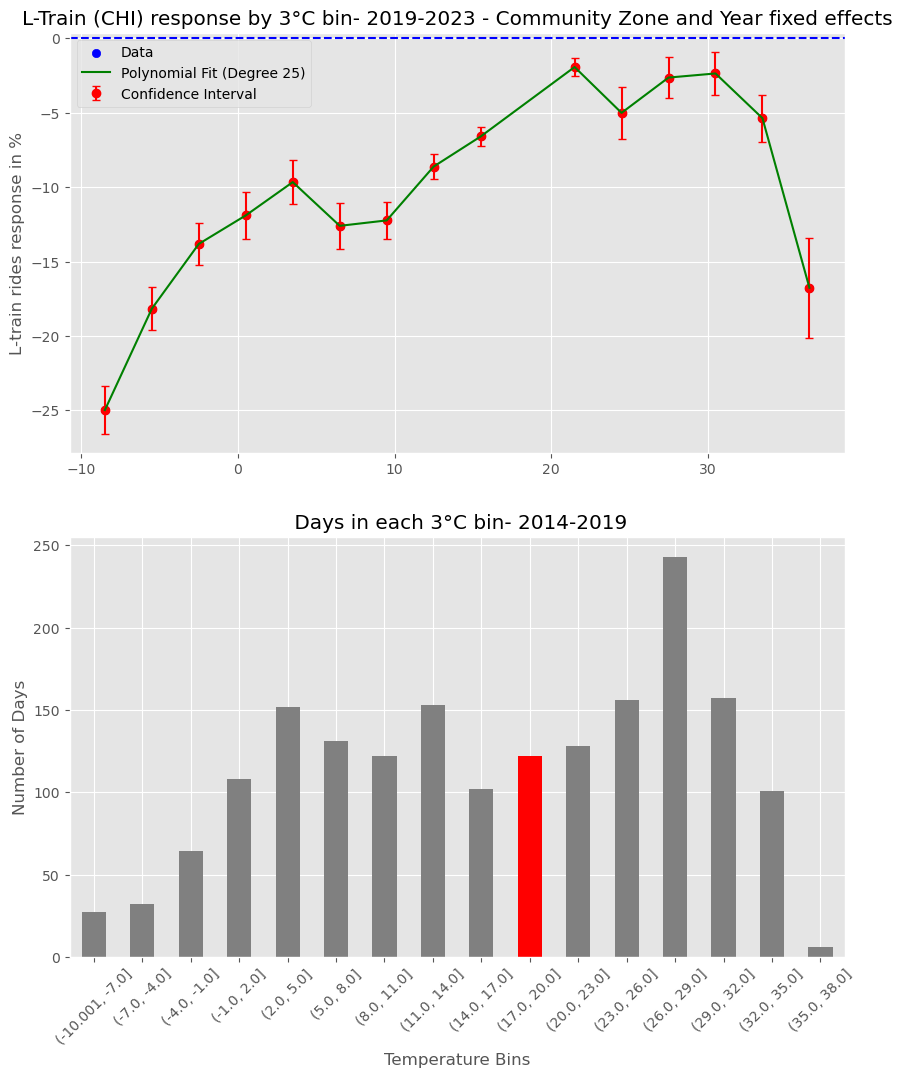

In [200]:
binned_regression_plots(3)

#### Neighborhood Plots + Neighborhood level regression

In [155]:
import statsmodels.api as sm
def run_zone_level_regression(data, PULocationID):
    """
    Run the regression for a given PULocationID, including time fixed effects,
    and return the results with heteroskedasticity-robust standard errors.
    
    Parameters:
    data (DataFrame): The panel data.
    PULocationID (int): The unique identifier for the location.
    
    Returns:
    dict: A dictionary with regression results for the given PULocationID.
    """
    # Subset the data for the current PULocationID
    temp_data = data[data['PULocationID'] == PULocationID]
    if temp_data.empty:
        print(f"The DataFrame is empty after filtering for {PULocationID}.")
    for col in ["tmax_obs", "log_total", "PRCP"]:
        if temp_data[col].nunique() <= 1:
            print(f"{col} has no variation for {PULocationID}.")
    
    

    
    model_formula = 'log_total ~ 1+  tmax_obs + PRCP + AWND + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + C(Year_fact)'

    # Fit the model from formula
    model = sm.formula.ols(formula=model_formula, data=temp_data)
    results = model.fit(cov_type='HC3')  
    # Extract results and return them in a dictionary
    return {
        'PULocationID': PULocationID,
        'Coefficient_tmax_obs': results.params.get('tmax_obs', float('nan')),
        'CI_lower': results.conf_int().loc['tmax_obs'][0] if 'tmax_obs' in results.params else float('nan'),
        'CI_upper': results.conf_int().loc['tmax_obs'][1] if 'tmax_obs' in results.params else float('nan'),
        'p_value_tmax_obs': results.pvalues.get('tmax_obs', float('nan')),
        'num_observations': results.nobs,
    }

# Load the data over 25 degrees

panel_data = pd.read_csv("Chigaco_data/train_prezone.csv")

panel_data =panel_data[panel_data["tmax_obs"] >= 26]

# Get unique PULocationIDs and apply the regression function to each
unique_ids = panel_data['PULocationID'].unique()
results = [run_zone_level_regression(panel_data, id) for id in unique_ids]

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a new CSV file
results_df.to_csv('Chigaco_data/Community_Zone_Results_Trains_count.csv', index=False)


In [149]:
import fiona
import geopandas as gpd
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [172]:
ca = gpd.read_file("Chigaco_data/boundaries_community_areas_chicago.geojson")
ca = ca.set_index('area_num_1')
ca.reset_index(level=0, inplace=True)
zone_results = pd.read_csv("Chigaco_data/Community_Zone_Results_Trains_count.csv")
zone_results["PULocationID"] = zone_results["PULocationID"].astype(str)
zoneresults_shape = ca.merge(zone_results, left_on='area_num_1', right_on = "PULocationID", how='left')
stations = gpd.read_file("Chigaco_data/Chicago_Public_Transport/L_Shapes/CTA_RailStations.shp")

zoneresults_shape.dropna(subset=['PULocationID'], inplace=True)
if stations.crs != zoneresults_shape.crs:
    stations = stations.to_crs(zoneresults_shape.crs)


C:\Users\max-admin\AppData\Local\Temp\ipykernel_4836\4116715788.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  label_positions = [(x, y) for x, y in zip(negative_zones.geometry.centroid.x, negative_zones.geometry.centroid.y)]


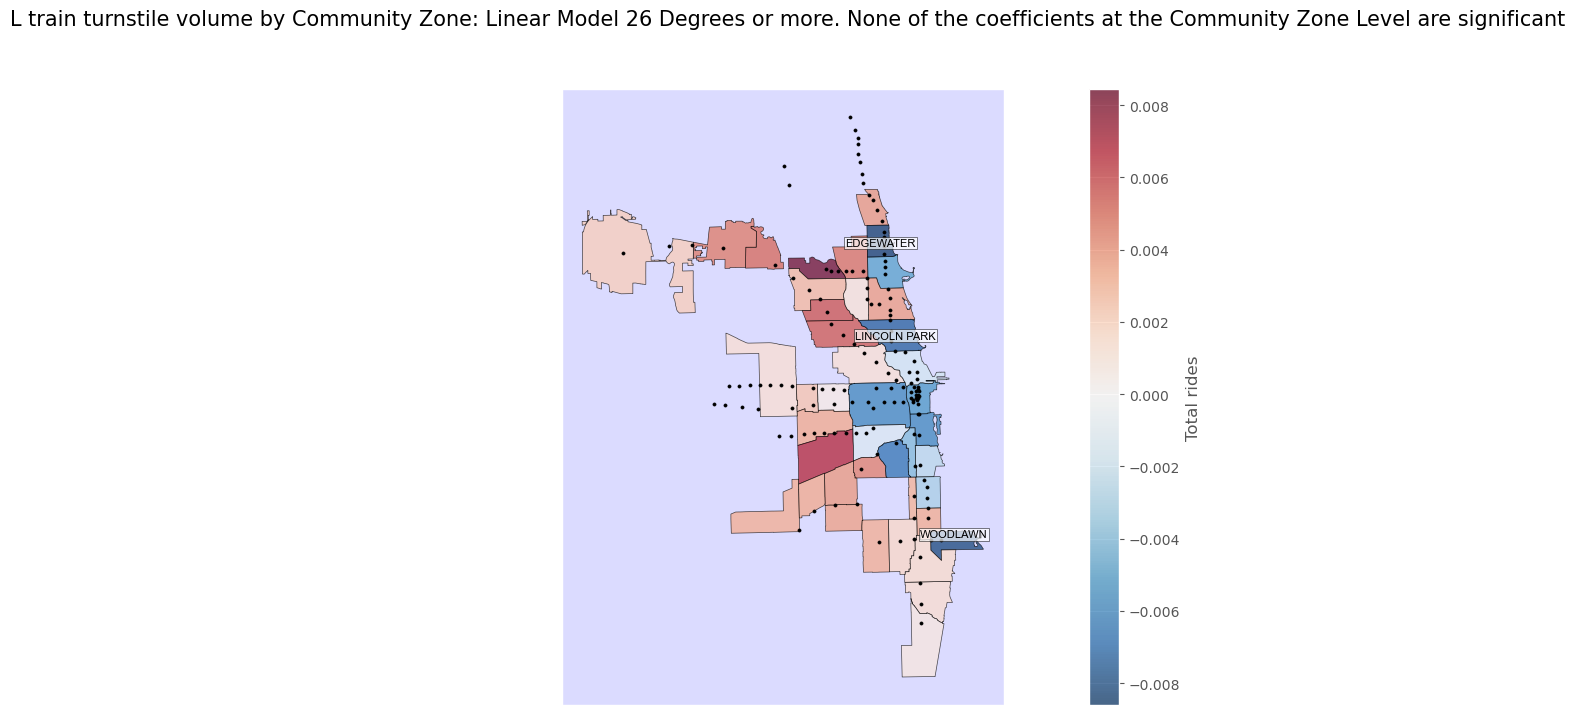

In [174]:
# Sort the DataFrame by 'Coefficient_tmax_obs' in descending order and get the top 5 zones
negative_zones = zoneresults_shape.sort_values('Coefficient_tmax_obs', ascending=True).head(3)

# Plot the data with more transparent facecolor
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
zoneresults_shape.plot(column='Coefficient_tmax_obs', ax=ax, cmap='RdBu_r', legend=False, edgecolor="black", alpha=0.7,
                       norm=colors.TwoSlopeNorm(vcenter=0))  # Normalize around zero

plt.suptitle('L train turnstile volume by Community Zone: Linear Model 26 Degrees or more. None of the coefficients at the Community Zone Level are significant', size=15)

# Add colorbar with adjusted transparency
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=zoneresults_shape['Coefficient_tmax_obs'].min(), vmax=zoneresults_shape['Coefficient_tmax_obs'].max()))
sm._A = []
cbar = plt.colorbar(sm, cax=cax, alpha=0.7)
cbar.set_label("Total rides")
# Manually adjust the positions of the text annotations
label_positions = [(x, y) for x, y in zip(negative_zones.geometry.centroid.x, negative_zones.geometry.centroid.y)]
label_offsets = [(0.001, -0.001), (0.001, 0.005), (0.001, -0.001), (0.001, -0.001), (0.001, -0.001)]

for i, label in enumerate(negative_zones.community):
    ax.text(label_positions[i][0] + label_offsets[i][0], label_positions[i][1] + label_offsets[i][1], label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.1', alpha=0.7), fontname='Arial')

# Remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor((0.8, 0.8, 1, 0.7))  # Set facecolor with adjusted transparency
stations.plot(ax=ax, color='black', markersize=5)
plt.show()